In [1]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
## USGS rain gage data

usgs_data_path = Path("usgs/usgs_data.pkl")

with open(usgs_data_path, "rb") as f:
    data = pickle.load(f)

daily, df, site_info, pcodes = data.values()
site_info

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,413104087440001,"RAIN GAGE AT MATTESON, IL",AT,413104,874400,41.517778,-87.733333,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS0,POINT (-87.73333 41.51778)
1,USGS,413510087380201,"RAIN GAGE AT HARVEY, IL",AT,413510,873802,41.586111,-87.633889,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.63389 41.58611)
2,USGS,413516087442101,"RAIN GAGE AT OAK FOREST, IL",AT,413516,874421,41.587778,-87.739167,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.73917 41.58778)
3,USGS,413548087395901,RAIN GAGE AT CALUMET UNION DR CANAL NR MARKHAM...,AT,413548,873959,41.596667,-87.666389,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001UM,POINT (-87.66639 41.59667)
4,USGS,414028087383501,"RAIN GAGE AT WEST PULLMAN AT CHICAGO, IL",AT,414028,873835,41.674444,-87.643056,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001CC,POINT (-87.64306 41.67444)
5,USGS,414030087450001,"RAIN GAGE AT ALSIP, IL",AT,414030,874500,41.675000,-87.750000,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.75 41.675)
6,USGS,415755087525300,"OHARE AIRPORT AT CHICAGO, IL",AT,415755,875253,41.965308,-87.881453,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,11303,POINT (-87.88145 41.96531)


In [3]:
pcodes

,parameter_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
0,00045,Physical,"Precipitation, total, inches",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,Precipitation,in
0,00020,Physical,"Temperature, air, degrees Celsius",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,"Temperature, air, deg C",deg C


In [4]:
## Radar point query data

DATE = "20210626"

radar_pfiles = Path(f"./timeseries/{DATE}").glob("*.csv")
radar_pfiles = sorted(radar_pfiles)
radar_pfiles

[PosixPath('timeseries/20210626/OHARE AIRPORT AT CHICAGO, IL.csv'),
 PosixPath('timeseries/20210626/RAIN GAGE AT ALSIP, IL.csv'),
 PosixPath('timeseries/20210626/RAIN GAGE AT CALUMET UNION DR CANAL NR MARKHAM, IL.csv'),
 PosixPath('timeseries/20210626/RAIN GAGE AT HARVEY, IL.csv'),
 PosixPath('timeseries/20210626/RAIN GAGE AT MATTESON, IL.csv'),
 PosixPath('timeseries/20210626/RAIN GAGE AT OAK FOREST, IL.csv'),
 PosixPath('timeseries/20210626/RAIN GAGE AT WEST PULLMAN AT CHICAGO, IL.csv')]

In [5]:
start = pd.Timestamp("2021-06-26T00:00:00", tz="UTC")
end = pd.Timestamp("2021-06-27T00:00:00", tz="UTC")

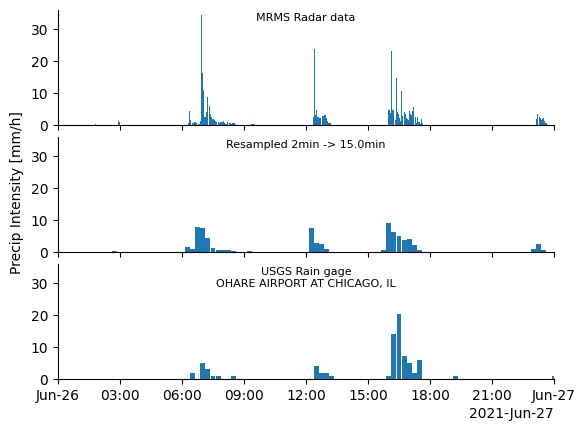

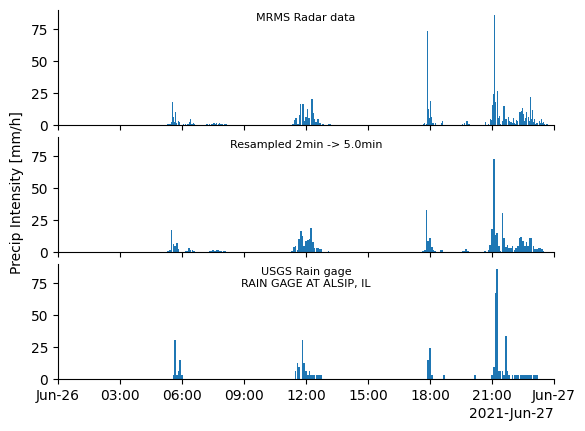

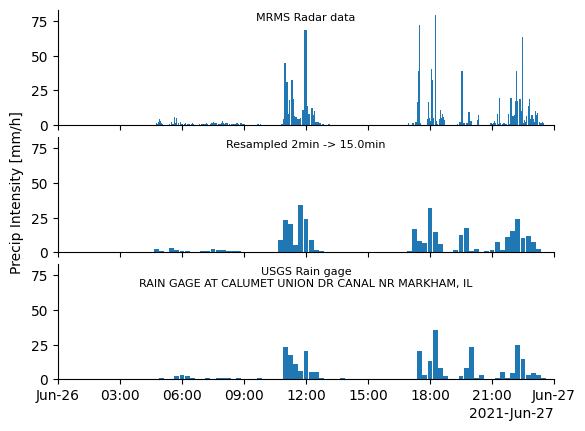

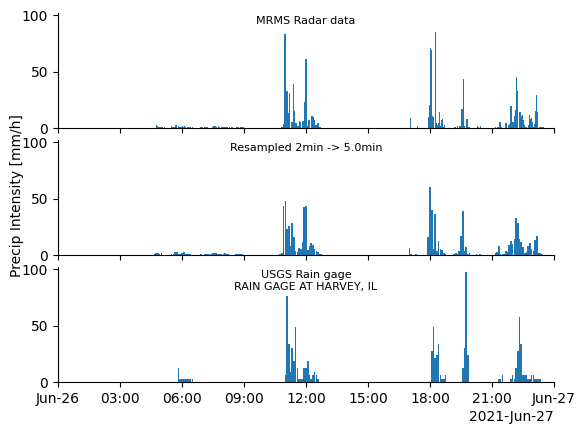

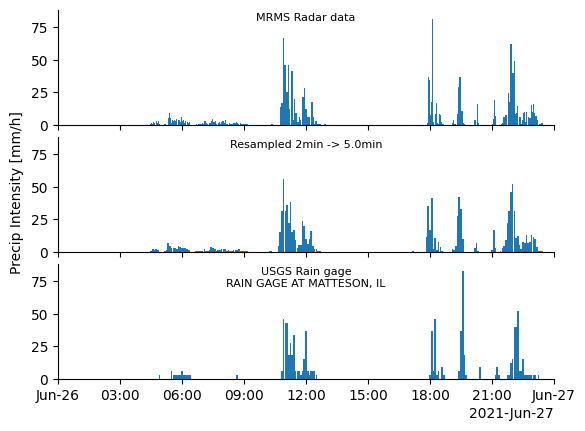

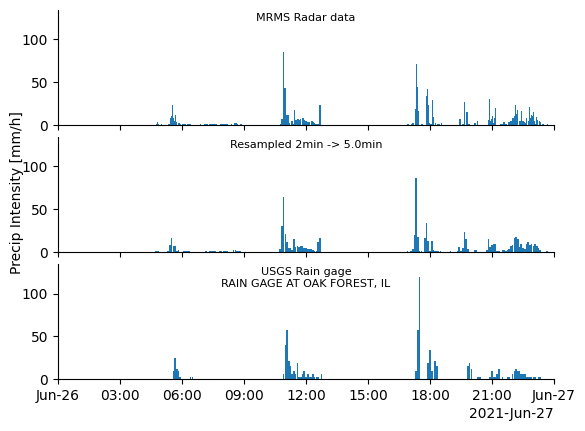

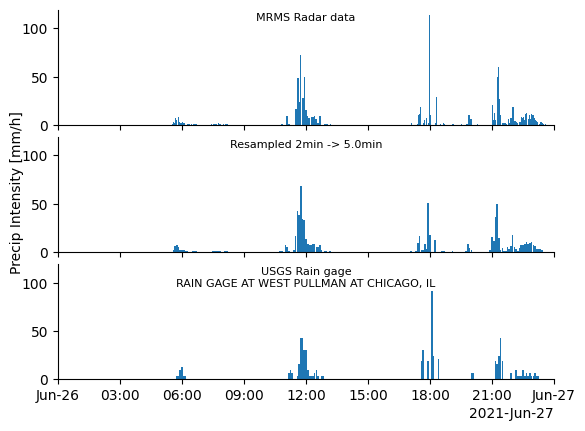

In [ ]:
for radar_pfile in radar_pfiles:
    station_name = radar_pfile.stem
    station_id = site_info.set_index("station_nm").loc[station_name]["site_no"]

    usgs_rain = df.xs(station_id).loc[start:end, "00045"]
    tdelta_usgs = np.diff(usgs_rain.index)[0]
    usgs_rain_mmhr = usgs_rain * 25.4 / (tdelta_usgs / pd.Timedelta("1h"))  # from in to mm/hr

    radar_rain = pd.read_csv(radar_pfile, index_col=0)
    radar_rain.index = pd.to_datetime(radar_rain.index)

    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, gridspec_kw={"hspace": 0.1})

    ax = axs[0]
    ax.set_title("MRMS Radar data", fontsize=8, va="top", y=0.9)
    ax.bar(radar_rain.index, radar_rain["value"], width=pd.Timedelta("1.8min"))

    ax = axs[1]
    downsampled = radar_rain.resample("1min").interpolate("linear")
    resampled = downsampled.resample(tdelta_usgs).mean()
    ax.set_title(f"Resampled 2min -> {tdelta_usgs.seconds / 60}min", fontsize=8, va="top", y=0.9)
    ax.bar(resampled.index, resampled["value"], width=0.95 * tdelta_usgs)

    ax = axs[2]
    ax.set_title(f"USGS Rain gage\n{station_name}", fontsize=8, va="top", y=0.9)
    ax.bar(usgs_rain.index, usgs_rain_mmhr, width=0.95 * tdelta_usgs)

    for ax in axs:
        ax.set_xlim(start, end)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
    fig.supylabel("Precip Intensity [mm/h]", fontsize=10, fontweight=300, x=0.05)
    plt.show()


,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.000000
2021-06-26 00:30:00+00:00,0.000000,0.000000
2021-06-26 01:00:00+00:00,0.000000,0.000000
2021-06-26 01:30:00+00:00,0.020000,0.000000
2021-06-26 02:00:00+00:00,0.000000,0.000000
2021-06-26 02:30:00+00:00,0.165000,0.000000
2021-06-26 03:00:00+00:00,0.015000,0.000000
2021-06-26 03:30:00+00:00,0.000000,0.000000
2021-06-26 04:00:00+00:00,0.000000,0.000000
2021-06-26 04:30:00+00:00,0.000000,0.000000


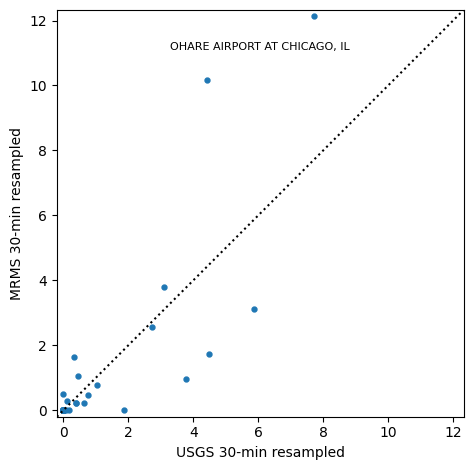

,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.0000
2021-06-26 00:30:00+00:00,0.000000,0.0000
2021-06-26 01:00:00+00:00,0.000000,0.0000
2021-06-26 01:30:00+00:00,0.000000,0.0000
2021-06-26 02:00:00+00:00,0.000000,0.0000
2021-06-26 02:30:00+00:00,0.000000,0.0000
2021-06-26 03:00:00+00:00,0.000000,0.0000
2021-06-26 03:30:00+00:00,0.000000,0.0000
2021-06-26 04:00:00+00:00,0.000000,0.0000
2021-06-26 04:30:00+00:00,0.000000,0.0000


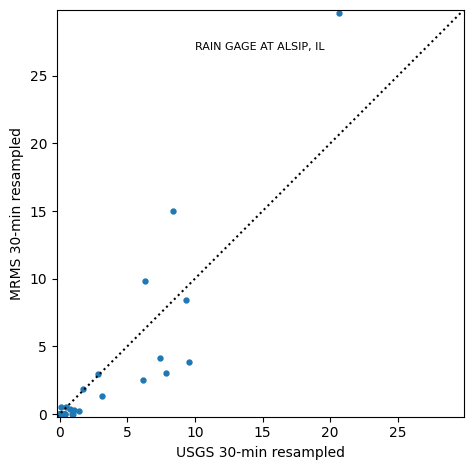

,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.000000
2021-06-26 00:30:00+00:00,0.000000,0.000000
2021-06-26 01:00:00+00:00,0.000000,0.000000
2021-06-26 01:30:00+00:00,0.000000,0.000000
2021-06-26 02:00:00+00:00,0.000000,0.000000
2021-06-26 02:30:00+00:00,0.000000,0.000000
2021-06-26 03:00:00+00:00,0.000000,0.000000
2021-06-26 03:30:00+00:00,0.000000,0.000000
2021-06-26 04:00:00+00:00,0.000000,0.000000
2021-06-26 04:30:00+00:00,1.021667,0.237067


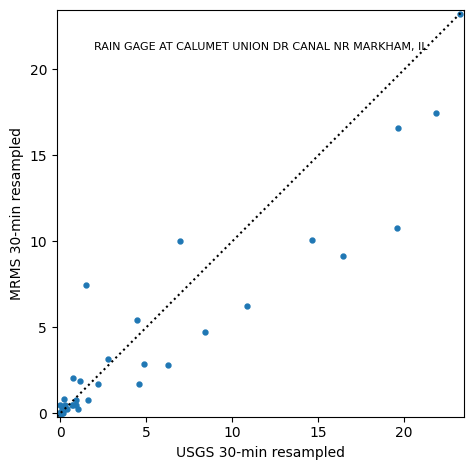

,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.0000
2021-06-26 00:30:00+00:00,0.000000,0.0000
2021-06-26 01:00:00+00:00,0.000000,0.0000
2021-06-26 01:30:00+00:00,0.000000,0.0000
2021-06-26 02:00:00+00:00,0.000000,0.0000
2021-06-26 02:30:00+00:00,0.000000,0.0000
2021-06-26 03:00:00+00:00,0.000000,0.0000
2021-06-26 03:30:00+00:00,0.000000,0.0000
2021-06-26 04:00:00+00:00,0.000000,0.0000
2021-06-26 04:30:00+00:00,0.930000,0.0000


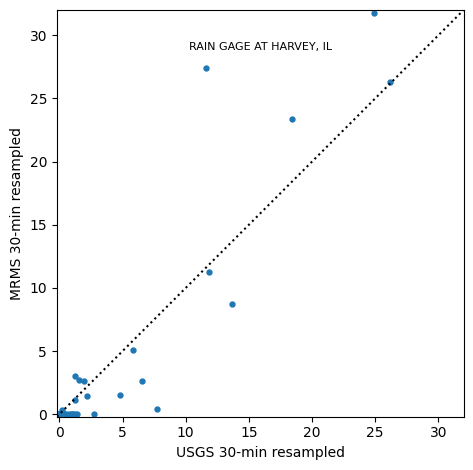

,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.0000
2021-06-26 00:30:00+00:00,0.000000,0.0000
2021-06-26 01:00:00+00:00,0.000000,0.0000
2021-06-26 01:30:00+00:00,0.000000,0.0000
2021-06-26 02:00:00+00:00,0.000000,0.0000
2021-06-26 02:30:00+00:00,0.000000,0.0000
2021-06-26 03:00:00+00:00,0.000000,0.0000
2021-06-26 03:30:00+00:00,0.000000,0.0000
2021-06-26 04:00:00+00:00,0.058333,0.0000
2021-06-26 04:30:00+00:00,1.486667,0.5080


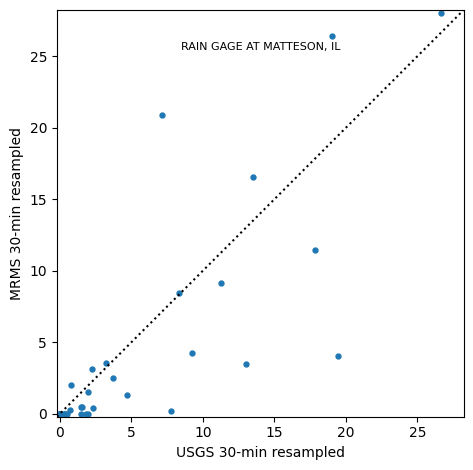

,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.0000
2021-06-26 00:30:00+00:00,0.000000,0.0000
2021-06-26 01:00:00+00:00,0.000000,0.0000
2021-06-26 01:30:00+00:00,0.000000,0.0000
2021-06-26 02:00:00+00:00,0.000000,0.0000
2021-06-26 02:30:00+00:00,0.000000,0.0000
2021-06-26 03:00:00+00:00,0.000000,0.0000
2021-06-26 03:30:00+00:00,0.000000,0.0000
2021-06-26 04:00:00+00:00,0.000000,0.0000
2021-06-26 04:30:00+00:00,0.516667,0.0000


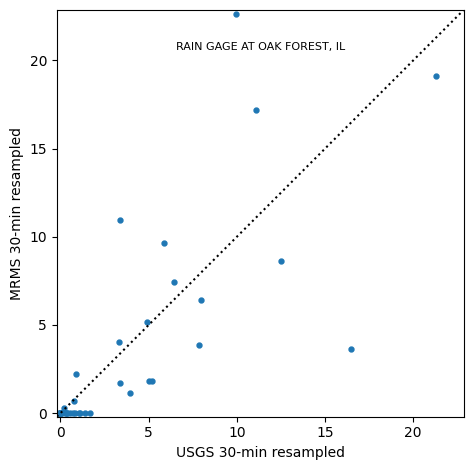

,value,00045
2021-06-26 00:00:00+00:00,0.000000,0.0000
2021-06-26 00:30:00+00:00,0.000000,0.0000
2021-06-26 01:00:00+00:00,0.000000,0.0000
2021-06-26 01:30:00+00:00,0.000000,0.0000
2021-06-26 02:00:00+00:00,0.000000,0.0000
2021-06-26 02:30:00+00:00,0.000000,0.0000
2021-06-26 03:00:00+00:00,0.000000,0.0000
2021-06-26 03:30:00+00:00,0.000000,0.0000
2021-06-26 04:00:00+00:00,0.000000,0.0000
2021-06-26 04:30:00+00:00,0.000000,0.0000


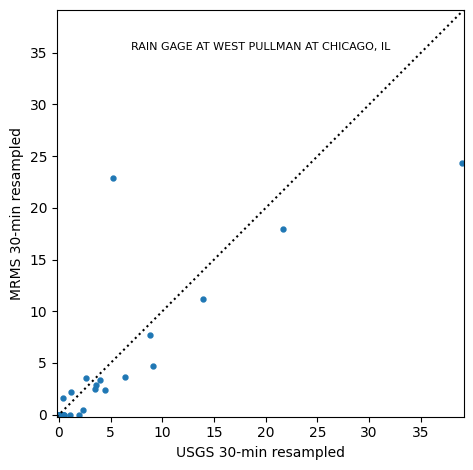

In [ ]:
for radar_pfile in radar_pfiles:
    station_name = radar_pfile.stem
    station_id = site_info.set_index("station_nm").loc[station_name]["site_no"]

    usgs_rain = df.xs(station_id).loc[start:end, "00045"]
    tdelta_usgs = np.diff(usgs_rain.index)[0]
    usgs_rain_mmhr = usgs_rain * 25.4 / (tdelta_usgs / pd.Timedelta("1h"))  # from in to mm/hr
    usgs_downsample = usgs_rain_mmhr.resample("1min").interpolate("linear")
    usgs_resample = usgs_downsample.resample(pd.Timedelta("30min")).mean()

    radar_rain = pd.read_csv(radar_pfile, index_col=0)
    radar_rain.index = pd.to_datetime(radar_rain.index, utc=True)
    radar_downsample = radar_rain.resample("1min").interpolate("linear")
    radar_resample = radar_downsample.resample(pd.Timedelta("30min")).mean()

    merged = pd.concat([radar_resample, usgs_resample], axis=1)
    display(merged)

    fig, ax = plt.subplots()
    ax.set_title(f"{station_name}", fontsize=8, va="top", y=0.9)
    ax.set_aspect("equal")
    ax.scatter(merged["value"], merged["00045"], marker=".", s=50)
    ax.set_xlabel("USGS 30-min resampled")
    ax.set_ylabel("MRMS 30-min resampled")
    ax.axline((0, 0), slope=1, ls="dotted", c="k")

    maxv = merged.max().max() + 0.2
    ax.set_xlim(-0.2, maxv)
    ax.set_ylim(-0.2, maxv)
    fig.tight_layout()
    plt.show()


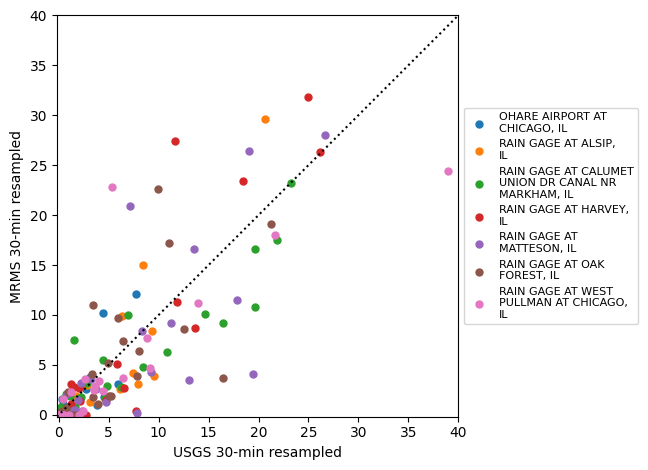

In [24]:
from textwrap import wrap

fig, ax = plt.subplots()

for radar_pfile in radar_pfiles:
    station_name = radar_pfile.stem
    station_id = site_info.set_index("station_nm").loc[station_name]["site_no"]

    usgs_rain = df.xs(station_id).loc[start:end, "00045"]
    tdelta_usgs = np.diff(usgs_rain.index)[0]
    usgs_rain_mmhr = usgs_rain * 25.4 / (tdelta_usgs / pd.Timedelta("1h"))  # from in to mm/hr
    usgs_downsample = usgs_rain_mmhr.resample("1min").interpolate("linear")
    usgs_resample = usgs_downsample.resample(pd.Timedelta("30min")).mean()

    radar_rain = pd.read_csv(radar_pfile, index_col=0)
    radar_rain.index = pd.to_datetime(radar_rain.index, utc=True)
    radar_downsample = radar_rain.resample("1min").interpolate("linear")
    radar_resample = radar_downsample.resample(pd.Timedelta("30min")).mean()

    merged = pd.concat([radar_resample, usgs_resample], axis=1)
    ax.scatter(
        merged["value"], merged["00045"], marker=".", s=100, label="\n".join(wrap(station_name, 20))
    )

ax.set_xlabel("USGS 30-min resampled")
ax.set_ylabel("MRMS 30-min resampled")
ax.axline((0, 0), slope=1, ls="dotted", c="k")
ax.set_aspect("equal")
ax.set_xlim(-0.2, 40)
ax.set_ylim(-0.2, 40)
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), prop={"size": 8})
fig.tight_layout()
plt.show()
